In [1]:
import torch
from torch import nn
from IPython.display import clear_output

from src.encoder import Encoder, GPT2Encoder
from src.decoder import Decoder, GPT2Decoder
from src.graph_initialization import random_unidirectional_graph_maker, linear_bidirectional_graph_maker
from src.graphAN import GraphAttentionNetwork, BlockGenerator
from src.data_loader import validation
from src.tokenizer import Tokenizer
from src.GPT2 import GPT2_Block, GPT2
from matplotlib import pyplot as plt
from src.utils import moving_average, grad_norm
from torch.nn.utils import clip_grad_norm_
import pickle
import numpy as np
from termcolor import colored
from torch.nn import functional as F
import einops

import torch

from src.cellular_automata import CellularAutomata
from src.tokenizer import CharTokenizer

dir_path='shakespeare_data/'
input_file_path=dir_path+'input.txt'


#create the tokenizer
tokenizer=CharTokenizer(input_file_path)
print('tokenizer vocab size:', tokenizer.vocab_size)

# load the data
with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")


# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = tokenizer(train_data)
val_ids = tokenizer(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
torch.save(train_ids, dir_path+'train.bin')
torch.save(val_ids,   dir_path+'val.bin')


length of dataset in characters: 1,115,394
tokenizer vocab size: 65
length of dataset in characters: 1,115,394
train has 1,003,854 tokens
val has 111,540 tokens


In [2]:
from src.cellular_automata import DiffusionLoss
from src.decoder import Loss
from src.encoder import NoiseEncoder


device = 'cpu'
#device = 'mps'  if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device

dK = 16
dV = 16
heads = 4
d_Embedding = dK*heads
intermediate_size=2*d_Embedding

encoder = NoiseEncoder(d_Embedding, tokenizer, dropout=0, device=device)
decoder = Decoder(encoder)
block_generator = BlockGenerator(GPT2_Block, d_Embedding, dK, dV, heads, intermediate_size,
                                 dropout=0.1, split_size=2**10, device=device, rotary_encoding=True)

model = CellularAutomata(tokenizer, encoder, block_generator, decoder, n_blocks=2)
model.logs={'loss':[],'step_loss':[], 'loss_components':[[],[],[]]}
model.tokens_seen=0

graph_maker = linear_bidirectional_graph_maker(64, device=device)

print(f'number of parameters:{model.n_parameters}')

lr = 2e-2
gamma = 0.99

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

step_weight=None


loss_function=DiffusionLoss(decoder,1e-2,1e-1)

number of parameters:73856


In [3]:
from numpy.random import randint
def sample_shakespeare(data, lenght, starting_index=None):
    lenght=int(lenght)
    
    if starting_index is None:
        starting_index = randint(0, len(data)-lenght)

    if starting_index+lenght>=len(data):
        return data[starting_index:]    
    
    return data[starting_index:starting_index+lenght]


def sample_minibatched_shakespeare(train_ids, context_size, batch_size):
    target = []
    prediction = []
    clean_encoding = []
    noise_encoding = []

    for _ in range(batch_size):
        targ=sample_shakespeare(train_ids, context_size)
        target.append(targ)
        noise=torch.rand(())

        pred, clean, nois = encoder(targ, noise)

        prediction.append(pred)
        clean_encoding.append(clean)
        noise_encoding.append(nois.repeat(pred.shape[0], 1))
        
    target = torch.cat(target, dim=0)
    prediction = torch.cat(prediction, dim=0)
    clean_encoding = torch.cat(clean_encoding, dim=0)
    noise_encoding = torch.cat(noise_encoding, dim=0)

    return prediction, clean_encoding, noise_encoding, target


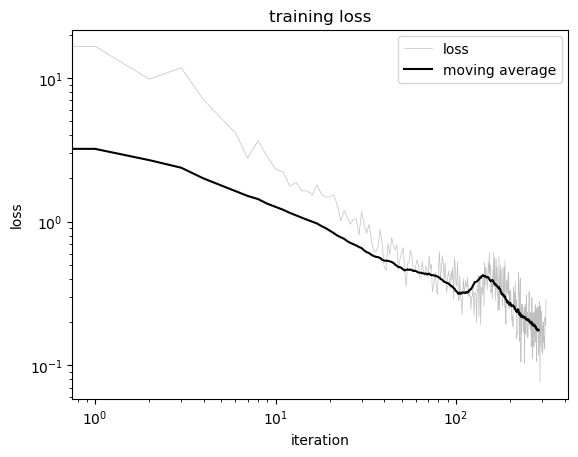

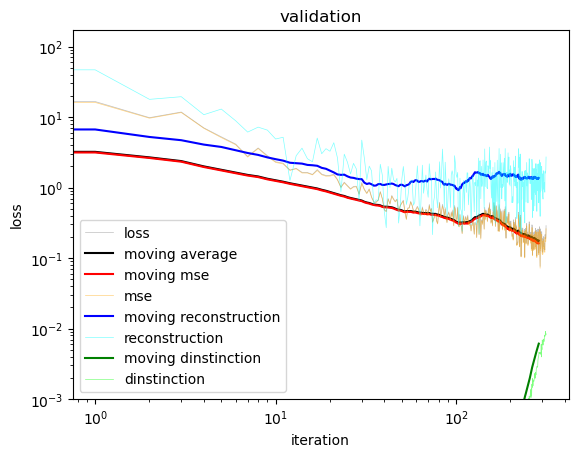

KeyboardInterrupt: 

In [8]:
#@title {vertical-output: true}
#@markdown # Training
#@markdown the loss function is cross entropy ❌🎲

batch_size=10

n_epochs = int(2000)
model.train()
context_size=100
model.train()
n_steps=10

edge_index = graph_maker(context_size)
edge_slide = torch.repeat_interleave(torch.arange(batch_size)*context_size, edge_index.shape[-1]).repeat(2,1)
edge_index=edge_index.repeat(1, batch_size) + edge_slide


for i in range(n_epochs):

    prediction, clean_encoding, noise_encoding, target = sample_minibatched_shakespeare(train_ids, context_size, batch_size)

    step_loss=torch.empty(n_steps+1, device=device)
    loss_components=torch.empty([n_steps+1,3], device=device)

    #do n steps 
    step_loss[0], loss_components[0]=loss_function(prediction, target, clean_encoding, noise_encoding)
    for j in range(1,n_steps+1):
        #make a forward pass
        prediction = model(prediction, edge_index)
        
        #compute loss
        step_loss[j], loss_components[j] = loss_function(prediction, target, clean_encoding, noise_encoding)
        #apply step weight if given
        if step_weight is not None:
            step_loss[j]*=step_weight(j)

    #compute the total loss
    loss = step_loss.mean()

    model.logs['loss'].append(loss.item())
    model.logs['step_loss'].append(step_loss.detach().cpu().numpy())
    for log,l in zip(model.logs['loss_components'],loss_components.mean(dim=0)):
        log.append(l.item())

    
    loss.backward()
    clip_grad_norm_(model.parameters(), 4*loss.item())


    optimizer.step()
    optimizer.zero_grad()  # reinitialize the gradient to zero
    model.tokens_seen+=context_size


    logging_interval=30
    if i%logging_interval==logging_interval-1:
        clear_output(wait=True)
        
        m_av = moving_average(model.logs['loss'], logging_interval-1)
        
        plt.plot(model.logs['loss'], label='loss', color='grey', alpha=0.5, linewidth=0.5)
        plt.plot(m_av, label='moving average', color='black')

        
        plt.title("training loss")
        plt.legend()
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.yscale('log')
        plt.xscale('log')
        plt.show()

        prediction, clean_encoding, noise_encoding, target = sample_minibatched_shakespeare(train_ids, context_size, batch_size)

        

        plt.plot(model.logs['loss'], label='loss', color='grey', alpha=0.5, linewidth=0.5)
        plt.plot(m_av, label='moving average', color='black')

        labels=["mse","reconstruction","dinstinction"]
        colors=[["red","orange"], ["blue", "cyan"], ["green", "lime"]]
        for log, label, color in zip(model.logs['loss_components'], labels, colors):
            m_av = moving_average(log, logging_interval-1)
            plt.plot(m_av, label=f'moving {label}', color=color[0])
            plt.plot(log, label=label, color=color[1], alpha=0.5, linewidth=0.5)



        plt.title("validation")
        plt.legend()
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.yscale('log')
        plt.xscale('log')
        plt.ylim(bottom=5e-2)
        plt.show()
        

In [ ]:
context_size=200
noise=torch.tensor(0.6)
targ=sample_shakespeare(train_ids, context_size)
print(f'original text:\n{tokenizer.decode(targ)}\n---------------------\n')
pred, clean, nois = encoder(targ, noise)

print(f'noised text:\n{tokenizer.decode(model.decoder(pred).argmax(dim=-1))}')

base_loss = loss_function(pred, targ, clean, nois)
print(f'loss befor denoising= {base_loss.item()}\n---------------------\n')

l=[]
edge_index=graph_maker(context_size)
for _ in range(20):
    pred = model(pred, edge_index)
    l.append(loss_function(pred, targ, clean, nois).item())

print(f'denoised text:\n{tokenizer.decode(model.decoder(pred).argmax(dim=-1))}\n---------------------\n')
base_loss = loss_function(pred, targ, clean, nois)
print(base_loss.item())


original text:


LUCIO:
Within two hours.

CLAUDIO:
Come, officer, away!

DUKE VINCENTIO:
No, holy father; throw away that thought;
Believe not that the dribbling dart of love
Can pierce a complete bosom. Why I desi
---------------------

noised text:
G
LUB'O:huith$n$too hours'

BLxU
C$:GConea officeRM away!

DGX- cINC
NTIO:
No,GhoEy fatherD throw awa$ that thoHght;
BAOie
e not that thn dwifb 'ng rart of lo-e
Can GierFe a co$Mlete bosoL. Ghn T wesi
loss befor denoising= 0.6489966511726379
---------------------

denoised text:
'
u nunwduithBn t:o hourn:
:HBduBCcF
Ooneu ouuiterU aoayo
'c'uf tBCC
Cugn:
uo  hous ;atheru throw adau that thoulBtd
Hfuie
e nFt that thu dridE 'ng rart oE lone
uan Hiewue a douulete aoroku phH H dssi
---------------------

0.15382419526576996


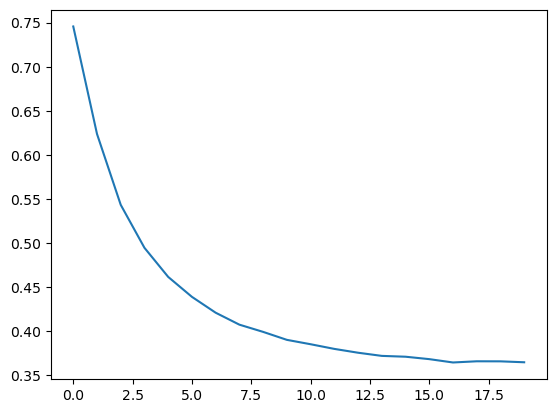

In [ ]:
plt.plot(l)

In [ ]:
print(10_000)

10000


In [ ]:
import matplotlib as mpl
encoding_prediction=[ log['loss']/(log['noise']+1e-8) for log in model.logs[-100:]]
colormap=plt.cm.get_cmap('viridis')

logs=model.logs
losses=[log['loss'] for log in logs]
noises=[log['noise'] for log in logs]
colors=colormap(np.logspace(-2.4,0,len(logs)))
plt.scatter(noises, losses, color=colors)


norm = mpl.colors.LogNorm(vmin=1, vmax=len(losses))
cmap=plt.cm.get_cmap('viridis_r')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),label='iterations',ticks=[])
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('noise')

KeyError: 'noise'

In [ ]:
from src.diffusion_utils import denoise,reverse_DDIM,cosine_schedule

encoding_prediction=torch.randn(200,model.d_Embedding)
edge_index=graph_maker(encoding_prediction.shape[0])

out=denoise(model, reverse_DDIM, encoding_prediction, 100,10, cosine_schedule,edge_index=edge_index)
tokenizer.decode(model.decoder(out).argmax(dim=-1).detach().cpu().numpy())

'ssssZi R$s-ssTWttoo s\n$rPMtIsost-ss\nWrWW$tro-ITXottrMx otoos-forxTsUswtUf Ur xUFU   t&tUoW&\n tUftU-sarItoowoUtl&t oI&ss-UI&E WnsUPz$t\ntn- IzIrt o;UUOo ottrt$ooosfss C IOWt& tUW X-w sMt StstttoIo TUWoI'

In [ ]:
tok=tokenizer(text)
out=model(tok, graph_maker(len(tok)))

loss_function(out[:-1], tok[1:])

out=model.calculate_final_embedding(out, graph_maker(len(tok)))
out.shape

torch.Size([180, 50257])

In [ ]:
import numpy as np

def scaling(N,D):
    return 406.4/N**.34 + 410.7/D**.28 + 1.69


noised_encoding=np.logspace(0,3,100,base=10)
gpt2_estimate=scaling(124e6,9e9)

In [ ]:
scaling(30e9,9e20)

1.8019184514787685

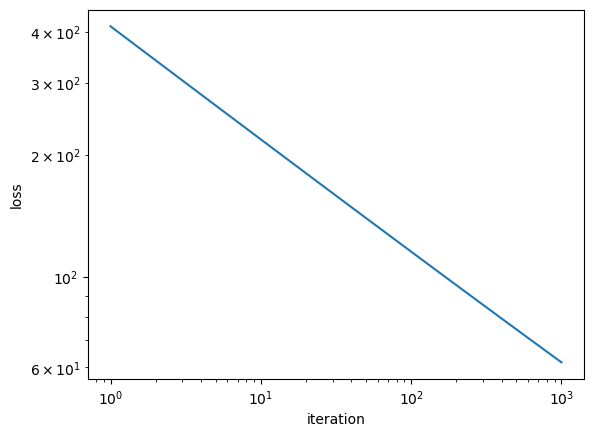

In [ ]:
from matplotlib import pyplot as plt

plt.plot(noised_encoding,y)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.yscale('log')
plt.xscale('log')
plt.show()